# Time Series Forecasting Assignment

## Table of Contents

1. Tasks
1. Imports
1. Helper Functions
1. Task1
1. Task2


## Tasks

![types](https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/assignment/deep-learning/time-series/time-series.jpg)

### Task1 
Given 10 timesteps of features, predict the USDT of the next timestep (many to one)

### Task2
Given 10 timestaps of features, predict the USDT of those timesteps (many to many)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Conv1D, SimpleRNN
import plotly.express as px


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

## Loading Data

### CSV Data Path 

In [3]:
data_path = 'https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/time-series/timeseries.csv'

### Reading CSV file with Pandas

In [4]:
data = pd.read_csv(data_path)

In [5]:
data.head()

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT
0,1.640560e+12,12-27-2021,XRP-USDT,0.9200,0.9237,0.9200,0.9226,2384512.0,2.198450e+06
1,1.640480e+12,12-26-2021,XRP-USDT,0.9252,0.9334,0.9052,0.9200,163438501.0,1.499400e+08
2,1.640390e+12,12-25-2021,XRP-USDT,0.9114,0.9350,0.8981,0.9252,250074945.0,2.302303e+08
3,1.640300e+12,12-24-2021,XRP-USDT,0.9941,0.9966,0.8964,0.9115,567234092.0,5.377035e+08
4,1.640220e+12,12-23-2021,XRP-USDT,0.9538,1.0167,0.9372,0.9941,479436230.0,4.729372e+08


### Normalizing Data

In [6]:
from sklearn import preprocessing

In [7]:
features = ['high', 'low', 'open', 'close', 'Volume XRP', 'Volume USDT']

0   unix         1334 non-null   float64
 1   date         1334 non-null   object 
 2   symbol       1334 non-null   object 
 3   open         1334 non-null   float64
 4   high         1334 non-null   float64
 5   low          1334 non-null   float64
 6   close        1334 non-null   float64
 7   Volume XRP   1334 non-null   float64
 8   Volume USDT  1334 non-null   float64

## Task1

### Data Preparation

Preparing the data for the first task

We will try to predict the value of USDT on the 11th day using the data of other features from day 1 to 10

In [8]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [9]:
def data_preparation(df, lookback, future, scaler):
    date_train=pd.to_datetime(df['date'])
    features = ['high', 'low', 'open', 'close', 'Volume XRP', 'Volume USDT']    
    df_train=df[features]
    df_train=df_train.astype(float)
    
    df_train_scaled = scaler.transform(df_train)

    X, y = [],[]
    for i in range(lookback, len(df_train_scaled)-future+1):
        X.append(df_train_scaled[i-lookback:i, 0:df_train.shape[1]])
        y.append(df_train_scaled[i+future-1:i+future, 0])
        
    return np.array(X), np.array(y), df_train, date_train


In [10]:
def predict(model, date_train,X_train, future_steps, ds):
    # Extracting dates
    dates = pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    # use the last future steps from X_train     
    predicted = model.predict(X_train[-future_steps:])
    predicted = np.repeat(predicted, ds.shape[1], axis=-1)
    nsamples, nx, ny = predicted.shape
    predicted = predicted.reshape((nsamples,nx*ny))

    return predicted, dates

def output_preparation(forecasting_dates, predictions, date_column = 'date', predicted_column='Volume USDT'):
    dates=[]
    for date in forecasting_dates:
        dates.append(date.date())
    predicted_df=pd.DataFrame(columns=[date_column, predicted_column])
    predicted_df[date_column] = pd.to_datetime(dates)
    predicted_df[predicted_column]= predictions
    return predicted_df

In [11]:
def results(df, lookback, future, scaler, col, X_train, y_train, df_train, date_train, model):
    predictions, forecasting_dates = predict(model, date_train, X_train, future, df)
    results = output_preparation(forecasting_dates, predictions)   
    print(results.head())
    fig = plt.plot(results['date'], results['Volume USDT'])
    plt.show()

In [12]:
scaler = StandardScaler()
features = ['high', 'low', 'open', 'close', 'Volume XRP', 'Volume USDT']    
df_train=data[features]
df_train=df_train.astype(float)

scaler = scaler.fit(df_train)
df_scaled = scaler.transform(df_train)

In [13]:
scaler_y = StandardScaler()
df_y = scaler_y.fit_transform(data[['Volume USDT']].to_numpy())

In [14]:
window_size = 10
future = 1
X_train, y_train, df_train, date_train = data_preparation(data, window_size, future, scaler)

### Modeling

#### ANN

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def ann_builder(X, y):
    model = tf.keras.models.Sequential()    
    model.add(Dense(12, activation='selu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
        loss='huber',
        optimizer=optimizer,
        metrics=['mse']
    )
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_ann.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = ann_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [16]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file
model_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/time-series/model/best_model_ann.h5"
model_path = get_file("best_model_ann.h5", model_url)
model = load_model(model_path)

1/1 [==============================] - 0s 133ms/step
        date  Volume USDT
0 2018-05-04     0.838457


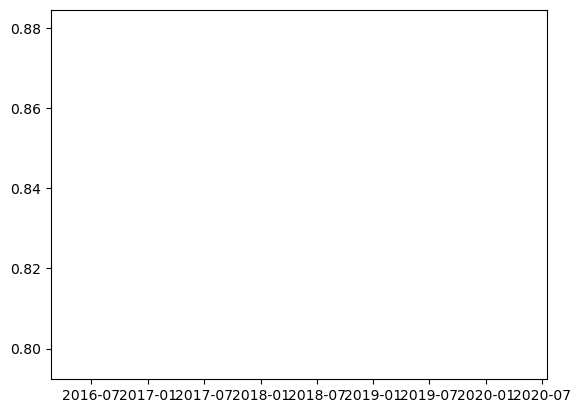

In [17]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

#### CNN

In [ ]:
def cnn_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(Conv1D(32, (3), activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_cnn.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = cnn_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

#### Simple RNN

In [ ]:
def rnn_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(SimpleRNN(1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_rnn.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = rnn_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

#### LSTM

In [ ]:
def lstm_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(LSTM(1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = lstm_builder(X_train,y_train)

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

## Task 2

Just setting future to 10 and the window to 10

In [ ]:
window_size = 20
future = 20
X_train, y_train, df_train, date_train = data_preparation(data, window_size, future, scaler)

Same models

### ANN


In [ ]:
def ann_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(Dense(32, activation='selu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_ann_2.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = ann_builder(X_train,y_train)

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

### RNN

In [ ]:
def rnn_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(SimpleRNN(1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_rnn_2.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = rnn_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

### CNN

In [ ]:
def cnn_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(Conv1D(32, (3), activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_cnn_2.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = cnn_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

### LSTM


In [ ]:
def lstm_builder(X,y):
    model = tf.keras.models.Sequential()    
    model.add(LSTM(1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(Dense(y.shape[1]))

    optimizer = tf.keras.optimizers.Adam()  
    model.compile(
            loss='huber',
            optimizer=optimizer,
            metrics=['mse']
        )
        
    callbacks = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint(filepath='best_model_lstm_2.h5', monitor='val_loss', save_best_only=True)]

    model.fit(X, y, epochs=50, verbose=1, validation_split=0.1, callbacks = callbacks, batch_size=16)
    return model

In [ ]:
model = lstm_builder(X_train, y_train)

In [ ]:
pd.DataFrame(model.history.history).plot()

In [ ]:
results(data, window_size, future, scaler, 'Volume USDT', X_train, y_train, df_train, date_train, model)

In [ ]:
# Acknowledgments

Thanks to Taha Bouhsine for creating the open-source course [ WTS2: Time Series Forecasting with TF ](https://www.kaggle.com/code/skywolfmo/wts2-time-series-forecasting-with-tf). It inspires the majority of the content in this chapter.